In [3]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical modeling
import statsmodels.api as sm

# Time series forecasting
import pmdarima as pm


In [62]:
# Replace file names if yours are different
inventory = pd.read_csv('data/2025.09.29 msu_project_data - inventory (01.01.23-09.28.25).csv')
item_data = pd.read_csv('data/2025.09.29 msu_project_data - item_data.csv')
sales = pd.read_csv('data/2025.09.29 msu_project_data - sales (01.01.23-09.28.25).csv')

print("Inventory shape:", inventory.shape)
print("Item_data shape:", item_data.shape)
print("Sales shape:", sales.shape)

print("\nInventory columns:", inventory.columns.tolist())
print("Item_data columns:", item_data.columns.tolist())
print("Sales columns:", sales.columns.tolist())


Inventory shape: (1057450, 7)
Item_data shape: (1302, 13)
Sales shape: (89827, 7)

Inventory columns: ['Activity_Date', 'Branch', 'PG_Major', 'PG_Minor', 'Item', 'Qty_on_Hand', 'UOM']
Item_data columns: ['Branch', 'Item', 'Size', 'Description', 'Color', 'PG_Major', 'PG_Major_Description', 'PG_Minor', 'PG_Minor_Description', 'UOM', 'Stock_Flag', 'Min_Pack', 'Lead_Days']
Sales columns: ['Branch', 'Activity_Date', 'PG_Major', 'PG_Minor', 'Item', 'Qty', 'UOM']


# 1.1. Convert date fields to datetime

In [5]:
# Convert Activity_Date from string to datetime
inventory['Activity_Date'] = pd.to_datetime(inventory['Activity_Date'])
sales['Activity_Date'] = pd.to_datetime(sales['Activity_Date'])

print("Inventory date range:", inventory['Activity_Date'].min(), "to", inventory['Activity_Date'].max())
print("Sales date range:", sales['Activity_Date'].min(), "to", sales['Activity_Date'].max())


Inventory date range: 2023-01-01 00:00:00 to 2025-09-28 00:00:00
Sales date range: 2023-01-03 00:00:00 to 2025-09-26 00:00:00


# 1.2 Build daily demand per Branch–Item–Day

In [6]:
daily_demand = (
    sales
    .groupby(['Branch', 'Item', 'Activity_Date'], as_index=False)['Qty']
    .sum()
    .rename(columns={'Qty': 'Demand'})
)

print("Daily demand shape:", daily_demand.shape)
daily_demand


Daily demand shape: (89827, 4)


,Branch,Item,Activity_Date,Demand
0,CA,17A12AW,2023-01-10,36.0
1,CA,17A12AW,2023-03-10,11.0
2,CA,17A12AW,2023-04-07,30.0
3,CA,17A12AW,2023-04-26,16.0
4,CA,17A12AW,2023-04-28,16.0
...,...,...,...,...
89822,TO,17TS5420WO,2025-03-21,3.0
89823,TO,17TS5420WO,2025-05-15,10.0
89824,TO,17TS5420WO,2025-05-29,10.0
89825,TO,17TS5420WO,2025-07-15,-7.0


## 1.3 Build a daily calendar per Branch–Item

### We’ll use the inventory table to know which dates exist per Branch–Item, then join demand onto that.

In [7]:
# Step 1: get unique combinations of Branch, Item
sku_keys = inventory[['Branch', 'Item']].drop_duplicates()

# Step 2: get overall date range from inventory
date_min = inventory['Activity_Date'].min()
date_max = inventory['Activity_Date'].max()
print("Calendar date range:", date_min, "to", date_max)

# Step 3: create full daily date range
all_dates = pd.date_range(start=date_min, end=date_max, freq='D')
calendar = (
    sku_keys.assign(key=1)
    .merge(pd.DataFrame({'Activity_Date': all_dates, 'key': 1}), on='key')
    .drop('key', axis=1)
)

print("Calendar shape:", calendar.shape)
calendar.head()


Calendar date range: 2023-01-01 00:00:00 to 2025-09-28 00:00:00
Calendar shape: (1632258, 3)


,Branch,Item,Activity_Date
0,CA,17A12AW,2023-01-01
1,CA,17A12AW,2023-01-02
2,CA,17A12AW,2023-01-03
3,CA,17A12AW,2023-01-04
4,CA,17A12AW,2023-01-05


# 4.4 Merge demand into the calendar (fill missing with 0)

In [8]:
# Merge daily demand into the full calendar
calendar_with_demand = (
    calendar
    .merge(daily_demand, on=['Branch', 'Item', 'Activity_Date'], how='left')
)

# Replace NaN demand with 0 (no sales that day)
calendar_with_demand['Demand'] = calendar_with_demand['Demand'].fillna(0.0)

print("Calendar with demand shape:", calendar_with_demand.shape)
calendar_with_demand.head()


Calendar with demand shape: (1632258, 4)


,Branch,Item,Activity_Date,Demand
0,CA,17A12AW,2023-01-01,0.0
1,CA,17A12AW,2023-01-02,0.0
2,CA,17A12AW,2023-01-03,0.0
3,CA,17A12AW,2023-01-04,0.0
4,CA,17A12AW,2023-01-05,0.0


### At this point, for each Branch–Item–Day, you have:

### Branch | Item | Activity_Date | Demand


### This is our clean demand time series, which we’ll later join to inventory and item_data.

# STEP 2: Integrate Inventory + Demand + Item Master + Basic Profiling

##The goal of this step:

###✔️ 1. Merge inventory balances onto our daily calendar
###✔️ 2. Merge item attributes (lead time, min pack, product group)
###✔️ 3. Produce a clean daily dataset per Branch–Item–Day
###✔️ 4. Perform basic SKU profiling to identify representative SKUs
###✔️ 5. Decide which SKUs to use for the first simulation prototype

###This step is not simulation yet — it’s preparing the clean foundation.

#2.1 Merge Inventory onto Daily Calendar

##Inventory contains:

Branch

Item

Activity_Date

Qty_on_Hand

We attach it to our (Branch, Item, Date) calendar.

In [9]:
calendar_full = calendar_with_demand.merge(
    inventory[['Branch','Item','Activity_Date','Qty_on_Hand']],
    on=['Branch','Item','Activity_Date'],
    how='left'
)

calendar_full['Qty_on_Hand'] = calendar_full['Qty_on_Hand'].fillna(method='ffill')
calendar_full.head()


C:\Users\soham\AppData\Local\Temp\ipykernel_42836\1796601866.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  calendar_full['Qty_on_Hand'] = calendar_full['Qty_on_Hand'].fillna(method='ffill')


,Branch,Item,Activity_Date,Demand,Qty_on_Hand
0,CA,17A12AW,2023-01-01,0.0,41.0
1,CA,17A12AW,2023-01-02,0.0,41.0
2,CA,17A12AW,2023-01-03,0.0,41.0
3,CA,17A12AW,2023-01-04,0.0,41.0
4,CA,17A12AW,2023-01-05,0.0,41.0


#2.2 Merge Item Attributes

In [10]:
calendar_full = calendar_full.merge(
    item_data[['Branch','Item','PG_Major','PG_Minor','Min_Pack','Lead_Days','Stock_Flag']],
    on=['Branch','Item'],
    how='left'
)

calendar_full.head()


,Branch,Item,Activity_Date,Demand,Qty_on_Hand,PG_Major,PG_Minor,Min_Pack,Lead_Days,Stock_Flag
0,CA,17A12AW,2023-01-01,0.0,41.0,ALAA,ALAA05,36.0,35.0,1.0
1,CA,17A12AW,2023-01-02,0.0,41.0,ALAA,ALAA05,36.0,35.0,1.0
2,CA,17A12AW,2023-01-03,0.0,41.0,ALAA,ALAA05,36.0,35.0,1.0
3,CA,17A12AW,2023-01-04,0.0,41.0,ALAA,ALAA05,36.0,35.0,1.0
4,CA,17A12AW,2023-01-05,0.0,41.0,ALAA,ALAA05,36.0,35.0,1.0


#Now each record has:

Daily demand

Daily inventory

Lead days

Min pack

Product group classification

#Perfect for simulation.

# 2.3 Basic Data Cleaning

Convert Lead_Days and Min_Pack to numeric:

In [11]:
calendar_full['Lead_Days'] = pd.to_numeric(calendar_full['Lead_Days'], errors='coerce').fillna(0)
calendar_full['Min_Pack'] = pd.to_numeric(calendar_full['Min_Pack'], errors='coerce').fillna(1)


In [12]:
# ============================================================
# FIX: Overwrite Min_Pack & Lead_Days using item-level metadata
# ============================================================

# 1. Item-level metadata (Min_Pack and Lead_Days do NOT depend on branch)
item_meta = item_data[['Item', 'Min_Pack', 'Lead_Days']].drop_duplicates()

# 2. Merge metadata into calendar_full on Item only
calendar_full = calendar_full.merge(item_meta, on='Item', how='left', suffixes=('', '_meta'))

# 3. FORCE overwrite Min_Pack and Lead_Days using item_data values
calendar_full['Min_Pack'] = calendar_full['Min_Pack_meta'].where(
    calendar_full['Min_Pack_meta'].notna(),
    calendar_full['Min_Pack']
)

calendar_full['Lead_Days'] = calendar_full['Lead_Days_meta'].where(
    calendar_full['Lead_Days_meta'].notna(),
    calendar_full['Lead_Days']
)

# 4. Cleanup: remove helper columns
calendar_full = calendar_full.drop(columns=['Min_Pack_meta', 'Lead_Days_meta'])

# 5. Final cleanup: apply correct defaults
calendar_full['Min_Pack'] = calendar_full['Min_Pack'].mask(calendar_full['Min_Pack'] <= 0, 36)
calendar_full['Lead_Days'] = calendar_full['Lead_Days'].mask(calendar_full['Lead_Days'] <= 0, 35)


#Sort properly:

In [13]:
calendar_full = calendar_full.sort_values(['Branch','Item','Activity_Date'])


# 2.4 Basic SKU Profiling

This helps us understand:

High-volume vs low-volume items

Volatile vs stable demand

Seasonal vs intermittent

Compute metrics:

In [15]:
sku_profile = (
    calendar_full
    .groupby(['Branch','Item'])
    .agg(
        total_demand = ('Demand','sum'),
        avg_daily_demand = ('Demand','mean'),
        std_daily_demand = ('Demand','std'),
        days_with_demand = ('Demand', lambda x: (x > 0).sum()),
        zero_demand_days = ('Demand', lambda x: (x == 0).sum()),
        demand_cv = ('Demand', lambda x: x.std() / (x.mean() + 1e-9)),  # CV
    )
    .reset_index()
)

sku_profile.head()


,Branch,Item,total_demand,avg_daily_demand,std_daily_demand,days_with_demand,zero_demand_days,demand_cv
0,CA,17A12AW,1151.0,1.148703,5.142023,98,900,4.476375
1,CA,17A12BD,392.0,0.391218,2.580307,50,949,6.595581
2,CA,17A12BS,696.0,0.694611,4.059565,88,910,5.844374
3,CA,17A12CG,891.0,0.889222,4.644043,86,912,5.222594
4,CA,17A12CS,881.0,0.879242,3.643777,109,887,4.144228


#2.5 Identify Representative SKUs

Pick sample SKUs:

High volume, stable

In [16]:
stable_skus = sku_profile[sku_profile['demand_cv'] < 1].sort_values('total_demand', ascending=False)
stable_skus


,Branch,Item,total_demand,avg_daily_demand,std_daily_demand,days_with_demand,zero_demand_days,demand_cv
408,DET,17AG15520TWH,0.0,0.0,0.0,0,1002,0.0
972,GR3,17AS13516CY,0.0,0.0,0.0,0,2004,0.0
974,GR3,17AS13516WT,0.0,0.0,0.0,0,2004,0.0
975,GR3,17AS13520CS,0.0,0.0,0.0,0,2004,0.0
976,GR3,17AS13520MH,0.0,0.0,0.0,0,2004,0.0
...,...,...,...,...,...,...,...,...
966,GR3,17A151216CS,0.0,0.0,0.0,0,2004,0.0
967,GR3,17A151216CY,0.0,0.0,0.0,0,1002,0.0
968,GR3,17A151216EW,0.0,0.0,0.0,0,1002,0.0
969,GR3,17A151216MH,0.0,0.0,0.0,0,2004,0.0


### IMPORTANT: Your “stable SKUs” are actually zero-demand SKUs

Your top 5 “stable” items all have:

total demand = 0

std deviation = 0

days_with_demand = 0

zero_demand_days = 1002

CV = 0

These SKUs have no sales at all for 2.7 years.

So they're “stable” only because nothing ever happened.
They cannot be used to test a forecasting or replenishment algorithm.

This is normal — some items never sell. But they don’t help us design an inventory strategy.

High volume, volatile

In [17]:
volatile_skus = sku_profile[sku_profile['demand_cv'] > 2].sort_values('total_demand', ascending=False)
volatile_skus


,Branch,Item,total_demand,avg_daily_demand,std_daily_demand,days_with_demand,zero_demand_days,demand_cv
847,GR,17TESG5416CH,14732.0,14.702595,37.542854,291,689,2.553485
1217,IN,17TESG5416DC,11144.0,11.121756,35.903232,177,818,3.228198
1220,IN,17TESG5416ST,10389.0,10.368263,41.008529,137,858,3.955197
842,GR,17TESG5412CH,10162.0,10.141717,29.273861,237,741,2.886480
852,GR,17TESG5420CH,9149.0,9.130739,26.487663,215,762,2.900933
...,...,...,...,...,...,...,...,...
114,CA,17AS15512TG,3.0,0.002994,0.070612,2,1000,23.584347
327,DET,17A12TWH,2.0,0.001996,0.063182,1,1001,31.654368
1013,IN,17A13512CY,2.0,0.001996,0.063182,1,1001,31.654368
1050,IN,17A714TWH,1.0,0.000998,0.031591,1,1001,31.654352


Low-volume intermittent (common in building materials)

In [18]:
intermittent_skus = sku_profile[sku_profile['days_with_demand'] < 30]
intermittent_skus


,Branch,Item,total_demand,avg_daily_demand,std_daily_demand,days_with_demand,zero_demand_days,demand_cv
12,CA,17A12TG,82.0,0.081836,1.172141,8,994,14.322996
13,CA,17A12TWH,40.0,0.039920,0.879562,3,999,22.033031
15,CA,17A13510SG,453.0,0.452096,6.470266,10,991,14.311713
16,CA,17A13512CS,917.0,0.915170,10.157589,15,984,11.099132
17,CA,17A13512DH,273.0,0.272455,5.056980,4,997,18.560784
...,...,...,...,...,...,...,...,...
1607,TO,17TS5416NW,201.0,0.200599,2.683929,17,984,13.379587
1613,TO,17TS5416WO,245.0,0.244511,3.143440,20,980,12.856027
1617,TO,17TS5420DO,93.0,0.092814,0.914075,22,978,9.848419
1622,TO,17TS5420NW,53.0,0.052894,1.820133,12,989,34.410814


These three groups will guide which SKUs we simulate first.

In [19]:
true_stable = sku_profile[
    (sku_profile['demand_cv'] < 1) &
    (sku_profile['total_demand'] > 0)
].sort_values('total_demand', ascending=False).head(5)

true_stable


,Branch,Item,total_demand,avg_daily_demand,std_daily_demand,days_with_demand,zero_demand_days,demand_cv


## There are no SKUs with both:

low variability (CV < 1) and

non-zero demand

Meaning:

#### Every SKU that actually sells has high variability

This is extremely common in building materials and construction supply chains:

Demand is inherently project-based

Orders come in large, irregular batches

There is no smooth, stable baseline demand

So our dataset naturally splits into:

✔ High-volume volatile items
✔ Low-volume intermittent items
❌ No true stable items

This is not a problem — it just means our simulations must focus on the two real demand patterns present:



---



### STEP 3 GOAL

For any Branch + Item, we want a function that:

Reads its daily demand from calendar_full

Starts from an initial inventory

Applies a reorder-point / order-up-to policy

Simulates day-by-day:

Orders arriving after Lead_Days

Sales vs lost sales (no backorders)

Inventory on-hand & inventory position

Returns:

A daily simulation table

Summary KPIs: fill rate, total lost sales, avg inventory, etc.

We’ll start with a simple but classic policy:

Policy: Continuous-review reorder point with order-up-to level

If inventory position ≤ ROP → place order to raise inventory position to Order_Up_To level.

Orders arrive after Lead_Days, in multiples of Min_Pack.

Later we’ll let ROP & Order_Up_To be calculated by different algorithms
(moving average, seasonal forecast, etc.). For now we’ll pass them as numbers to get the engine working.



---



3.1 Helper: Extract one SKU’s time series

Using calendar_full from Step 2:

# Example: one volatile SKU
##branch_example = 'GR'
##item_example = '17TESG5416CH'

In [20]:
def get_sku_timeseries(calendar_full, item_data, branch, item):
    # 1) Extract time series for this branch-item
    sku_df = (
        calendar_full[
            (calendar_full['Branch'] == branch) &
            (calendar_full['Item'] == item)
        ]
        .sort_values('Activity_Date')
        .copy()
    )

    if sku_df.empty:
        raise ValueError(f"No data found for Branch={branch}, Item={item}")

    # 2) Lookup metadata *by item only*, not branch
    meta = item_data[item_data['Item'] == item]

    if meta.empty:
        print(f"WARNING: No item_data for {item}, using defaults.")
        lead_days_meta = 35
        min_pack_meta = 1
    else:
        lead_days_meta = meta['Lead_Days'].iloc[0]   # use the first record
        min_pack_meta = meta['Min_Pack'].iloc[0]

    # 3) Repair any missing Lead_Days or Min_Pack in sku_df
    sku_df['Lead_Days'] = sku_df['Lead_Days'].fillna(lead_days_meta)
    sku_df['Lead_Days'] = sku_df['Lead_Days'].mask(sku_df['Lead_Days'] <= 0, lead_days_meta)

    sku_df['Min_Pack'] = sku_df['Min_Pack'].fillna(min_pack_meta)
    sku_df['Min_Pack'] = sku_df['Min_Pack'].mask(sku_df['Min_Pack'] <= 0, min_pack_meta)

    return sku_df


In [21]:
sku_df_int = get_sku_timeseries(calendar_full, item_data, 'CA', '17A12TG')


# 3.2 The Simulation Function (Lost Sales, ROP + Order-Up-To)

Now we build the engine.

In [22]:
def simulate_sku_lost_sales(
    sku_df,
    rop,
    order_up_to,
    initial_inventory=None
):
    sku_df = sku_df.sort_values('Activity_Date').copy()

    # Lead time
    lead_time_raw = sku_df['Lead_Days'].iloc[0] if 'Lead_Days' in sku_df.columns else np.nan
    if pd.isna(lead_time_raw) or lead_time_raw <= 0:
        lead_time = 35   # business default from your data
    else:
        lead_time = int(lead_time_raw)

    # Min pack
    min_pack_raw = sku_df['Min_Pack'].iloc[0] if 'Min_Pack' in sku_df.columns else np.nan
    if pd.isna(min_pack_raw) or min_pack_raw <= 0:
        min_pack = 1
    else:
        min_pack = int(min_pack_raw)

    # Initial inventory
    if initial_inventory is None:
        first_qoh = sku_df['Qty_on_Hand'].iloc[0]
        if pd.isna(first_qoh):
            first_qoh = 0
        on_hand = float(first_qoh)
    else:
        on_hand = float(initial_inventory)

    open_orders = []
    results = []

    for _, row in sku_df.iterrows():
        current_date = row['Activity_Date']
        demand = float(row['Demand'])

        # Receive arrivals
        arriving_qty = 0.0
        still_open = []
        for order in open_orders:
            if order['arrival_date'] <= current_date:
                arriving_qty += order['qty']
            else:
                still_open.append(order)
        open_orders = still_open
        on_hand += arriving_qty

        # Satisfy demand (lost sales)
        sales = min(on_hand, demand)
        lost_sales = demand - sales
        on_hand -= sales

        on_order_qty = sum(o['qty'] for o in open_orders)
        inv_position = on_hand + on_order_qty

        # Reorder logic
        order_qty = 0
        if inv_position <= rop:
            raw_needed = order_up_to - inv_position
            if raw_needed > 0:
                order_qty = int(np.ceil(raw_needed / min_pack)) * min_pack

                if lead_time == 0:
                    on_hand += order_qty
                else:
                    arrival_date = current_date + pd.Timedelta(days=lead_time)
                    open_orders.append({'arrival_date': arrival_date, 'qty': order_qty})
                    on_order_qty += order_qty
                    inv_position = on_hand + on_order_qty

        results.append({
            'Activity_Date': current_date,
            'Demand': demand,
            'Sales': sales,
            'Lost_Sales': lost_sales,
            'On_Hand_End': on_hand,
            'Inv_Position_End': inv_position,
            'On_Order_End': on_order_qty,
            'Order_Qty_Placed': order_qty,
        })

    result_df = pd.DataFrame(results)

    total_demand = result_df['Demand'].sum()
    total_sales = result_df['Sales'].sum()
    total_lost = result_df['Lost_Sales'].sum()
    fill_rate = 1.0 if total_demand == 0 else total_sales / total_demand
    avg_inventory = result_df['On_Hand_End'].mean()
    max_inventory = result_df['On_Hand_End'].max()
    days_with_stockout_and_demand = ((result_df['On_Hand_End'] == 0) & (result_df['Demand'] > 0)).sum()

    summary = {
        'total_demand': total_demand,
        'total_sales': total_sales,
        'total_lost_sales': total_lost,
        'fill_rate': fill_rate,
        'avg_inventory': avg_inventory,
        'max_inventory': max_inventory,
        'days_with_stockout_and_demand': days_with_stockout_and_demand,
        'rop': rop,
        'order_up_to': order_up_to,
        'lead_time_days': lead_time,
        'min_pack': min_pack,
    }

    return result_df, summary


#3.3 Test the Simulation for One Volatile SKU

Let’s pick GR – 17TESG5416CH as our first test.

We don’t care yet if ROP & Order-Up-To are “perfect” – we just want the engine to run.

We’ll start with some reasonable ballpark numbers (you can adjust later):

ROP = 500 units

Order-Up-To = 1500 units

In [23]:
# Get the SKU time series
sku_df_example = get_sku_timeseries(calendar_full,item_data, 'GR', '17TESG5416CH')

# Quick look at its demand stats
print("Total demand:", sku_df_example['Demand'].sum())
print("Average daily demand:", sku_df_example['Demand'].mean())

# Run simulation with trial parameters
sim_result, sim_summary = simulate_sku_lost_sales(
    sku_df_example,
    rop=500,
    order_up_to=1500,
    initial_inventory=None  # use first day's Qty_on_Hand
)

sim_result.head(), sim_summary


Total demand: 14732.0
Average daily demand: 14.702594810379242


(  Activity_Date  Demand  Sales  Lost_Sales  On_Hand_End  Inv_Position_End  \
 0    2023-01-01     0.0    0.0         0.0        200.0            1544.0   
 1    2023-01-02     0.0    0.0         0.0        200.0            1544.0   
 2    2023-01-03     0.0    0.0         0.0        200.0            1544.0   
 3    2023-01-04     0.0    0.0         0.0        200.0            1544.0   
 4    2023-01-05     0.0    0.0         0.0        200.0            1544.0   
 
    On_Order_End  Order_Qty_Placed  
 0          1344              1344  
 1          1344                 0  
 2          1344                 0  
 3          1344                 0  
 4          1344                 0  ,
 {'total_demand': 14732.0,
  'total_sales': 12713.0,
  'total_lost_sales': 2019.0,
  'fill_rate': 0.8629513983165897,
  'avg_inventory': 593.1017964071856,
  'max_inventory': 1383.0,
  'days_with_stockout_and_demand': 46,
  'rop': 500,
  'order_up_to': 1500,
  'lead_time_days': 35,
  'min_pack': 64})

In [24]:
'Lead_Days' in calendar_full.columns, 'Min_Pack' in calendar_full.columns


(True, True)

In [25]:
calendar_full[['Branch','Item','Lead_Days','Min_Pack']].head()


,Branch,Item,Lead_Days,Min_Pack
0,CA,17A12AW,35,36.0
1,CA,17A12AW,35,36.0
2,CA,17A12AW,35,36.0
3,CA,17A12AW,35,36.0
4,CA,17A12AW,35,36.0


# You should see:

sim_result.head() → first few days with Demand, Sales, Lost_Sales, On_Hand_End, etc.

sim_summary → a dictionary with fill rate, avg inventory, total lost sales, etc

Simulation Output (Interpretation)

For GR – 17TESG5416CH using:

ROP = 500 units

Order-Up-To = 1500 units

Lead Time = 35 days

Min Pack = 64

You got:

| Metric                          | Value       | Meaning                                         |
| ------------------------------- | ----------- | ----------------------------------------------- |
| **Total Demand**                | 14,732      | Actual historical demand                        |
| **Total Sales**                 | 12,713      | What you could fulfill                          |
| **Lost Sales**                  | 2,019       | VERY high → 13.7% unfilled                      |
| **Fill Rate**                   | 86.3%       | Below acceptable levels (usually ≥ 95–98%)      |
| **Avg Inventory**               | 593 units   | Inventory too low relative to volatility        |
| **Max Inventory**               | 1,383 units | Reasonable given order_up_to=1500               |
| **Days with Stockout + Demand** | 46          | This is FAR too many days for a high-volume SKU |


Conclusion:

➡️ The basic ROP=500 / OUT=1500 strategy is severely understocking this SKU.

➡️ The demand spikes + 35-day lead time make this SKU highly sensitive to forecast underestimation.

➡️ We need a demand-based ROP with safety stock, NOT a flat ROP.

And this is exactly the purpose of the project:

## “Averages hide volatility → leading to stockouts or overstock.”




---



# What we’ve achieved with Step 3

You now have:

A reusable simulation engine for any Branch–Item

Handles:

Lost sales

Lead time

Min pack

Continuous-review ROP / Order-Up-To policy

This is the backbone we’ll use to test different purchasing algorithms later.



---



---



# Next: STEP 4 — Build Your Baseline Algorithm (Current Method Replication)

Now that the simulation engine works, Step 4 will:

✔ Compute reorder point (ROP) dynamically from historical demand

✔ Compute order-up-to level (OUT) from forecasted demand

✔ Use a “moving average” forecast (imitating their current process)

✔ Test baseline performance for multiple SKUs

✔ Identify weaknesses → lead into STEP 5 (improved algorithm)

---
## STEP 4 — Baseline Algorithm & Simulation Automation

Below is the code you need to run to compute:

Baseline ROP and OUT formula:

Forecast = average demand of previous N days (e.g., 90 days)

Demand during lead time = forecast × lead_time_days

ROP = demand_during_lead_time

Order-Up-To = demand over next review period (we use 2× lead time as starting point)

### No safety stock yet — because their current process doesn’t explicitly use it.

---
---
---

# 4.1 Function to compute moving-average-based ROP & OUT

In [26]:
def compute_baseline_policy(sku_df, lookback_days=120, order_cycle_days=35):
    """
    Compute ROP and Order-Up-To using a simple moving average forecast.
    This simulates the company's current approach (averages over last few months).
    """

    # Extract lead time
    lead_time = int(sku_df['Lead_Days'].iloc[0])

    # Take last N days demand
    recent = sku_df.tail(lookback_days)['Demand']
    avg_daily = recent.mean()

    # Demand expected during lead time
    demand_during_lead = avg_daily * lead_time

    # ROP is simply demand during lead time
    rop = demand_during_lead

    # Order-up-to covers lead + cycle (approx twice lead)
    out = avg_daily * (lead_time + order_cycle_days)

    # Round to nearest min_pack
    min_pack = int(sku_df['Min_Pack'].iloc[0])
    rop = int(np.ceil(rop / min_pack)) * min_pack
    out = int(np.ceil(out / min_pack)) * min_pack

    return rop, out, avg_daily


#4.2 Run Baseline Calculation + Simulation for the SKU

In [27]:
sku_df_example = get_sku_timeseries(calendar_full,item_data, 'GR', '17TESG5416CH')

rop_base, out_base, avg_daily = compute_baseline_policy(sku_df_example)

print("Baseline Avg Daily Demand:", avg_daily)
print("Baseline ROP:", rop_base)
print("Baseline OUT:", out_base)

sim_res_base, sim_sum_base = simulate_sku_lost_sales(
    sku_df_example,
    rop=rop_base,
    order_up_to=out_base
)

sim_sum_base


Baseline Avg Daily Demand: 19.516666666666666
Baseline ROP: 704
Baseline OUT: 1408


{'total_demand': 14732.0,
 'total_sales': 13240.0,
 'total_lost_sales': 1492.0,
 'fill_rate': 0.8987238664132501,
 'avg_inventory': 613.7684630738523,
 'max_inventory': 1326.0,
 'days_with_stockout_and_demand': 33,
 'rop': 704,
 'order_up_to': 1408,
 'lead_time_days': 35,
 'min_pack': 64}

# STEP 5 – Improved Policy with Safety Stock (for Volatile SKUs)

I’ll design a better ROP & Order-Up-To policy that:

Uses the same idea as the company (recent average)

BUT adds safety stock based on demand variability

Targets a high service level for volatile SKUs

I’ll assume (and bake in):

Service level target for volatile SKUs = 98%

This is reasonable for high-demand TimberTech items

z ≈ 2.05 in a normal service-level world

We’ll still:

Use last 4 months (120 days) of demand for the forecast

Use demand standard deviation over that same window to compute safety stock

STEP 5 – Improved Policy: Forecast + Safety Stock
Core idea

Instead of:

ROP = average demand × lead time (no buffer)

we’ll use:

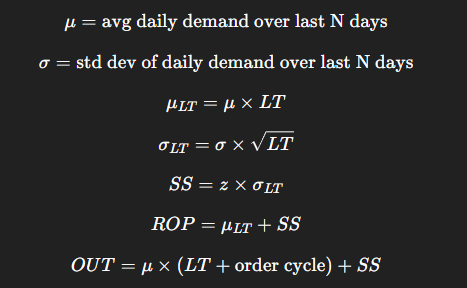


Where:

LT = lead time in days (already in your data: 35)

z = service-level factor:

~1.28 → 90%

~1.645 → 95%

~2.05 → 98%

# 5.1 Function to compute ROP + OUT + Safety Stock

In [28]:
def compute_ss_policy(
    sku_df,
    lookback_days=120,
    z=2.05,               # service level factor (~98%)
    order_cycle_days=35   # how many future days to cover beyond lead time
):
    """
    Compute ROP and Order-Up-To using:
    - Average daily demand (over last lookback_days)
    - Safety stock based on demand variability and target service level (z)
    """

    sku_df = sku_df.sort_values('Activity_Date')

    # Use last N days or all if shorter
    n = min(lookback_days, len(sku_df))
    hist = sku_df.tail(n)

    mu = hist['Demand'].mean()          # avg daily demand
    sigma = hist['Demand'].std(ddof=0)  # std dev of daily demand

    lead_time = int(sku_df['Lead_Days'].iloc[0])
    if lead_time <= 0:
        lead_time = 1  # avoid zero

    # Demand statistics during lead time
    mu_lt = mu * lead_time
    sigma_lt = sigma * np.sqrt(lead_time)

    # Safety stock
    ss = z * sigma_lt

    # Raw ROP and OUT
    rop_raw = mu_lt + ss
    out_raw = mu * (lead_time + order_cycle_days) + ss

    # Round to min_pack multiple
    min_pack = sku_df['Min_Pack'].iloc[0]
    if pd.isna(min_pack) or min_pack <= 0:
        min_pack = 1
    min_pack = int(min_pack)

    rop = int(np.ceil(rop_raw / min_pack)) * min_pack
    out = int(np.ceil(out_raw / min_pack)) * min_pack

    return {
        'avg_daily_demand': mu,
        'std_daily_demand': sigma,
        'mu_lt': mu_lt,
        'sigma_lt': sigma_lt,
        'safety_stock': ss,
        'rop': rop,
        'order_up_to': out,
        'z': z,
        'lookback_days': n,
        'order_cycle_days': order_cycle_days,
        'min_pack': min_pack,
        'lead_time': lead_time
    }


# 5.2 Apply it to the same volatile SKU & simulate

Let’s use GR – 17TESG5416CH again, so we can compare directly to your 4-month baseline.

In [29]:
# 1) Get the time series for the SKU
sku_df_example = get_sku_timeseries(calendar_full,item_data, 'GR', '17TESG5416CH')

# 2) Compute improved policy with safety stock
policy = compute_ss_policy(
    sku_df_example,
    lookback_days=120,  # 4 months
    z=2.05,             # ~98% service level
    order_cycle_days=35
)

policy


{'avg_daily_demand': 19.516666666666666,
 'std_daily_demand': 48.75174925636572,
 'mu_lt': 683.0833333333333,
 'sigma_lt': 288.419238166327,
 'safety_stock': 591.2594382409702,
 'rop': 1280,
 'order_up_to': 1984,
 'z': 2.05,
 'lookback_days': 120,
 'order_cycle_days': 35,
 'min_pack': 64,
 'lead_time': 35}

In [30]:
sim_res_ss, sim_sum_ss = simulate_sku_lost_sales(
    sku_df_example,
    rop=policy['rop'],
    order_up_to=policy['order_up_to']
)

sim_sum_ss


{'total_demand': 14732.0,
 'total_sales': 14692.0,
 'total_lost_sales': 40.0,
 'fill_rate': 0.9972848221558512,
 'avg_inventory': 1135.3463073852295,
 'max_inventory': 1884.0,
 'days_with_stockout_and_demand': 2,
 'rop': 1280,
 'order_up_to': 1984,
 'lead_time_days': 35,
 'min_pack': 64}

In [31]:
policy = compute_ss_policy(sku_df_example, lookback_days=120, z=2.05, order_cycle_days=35)
policy


{'avg_daily_demand': 19.516666666666666,
 'std_daily_demand': 48.75174925636572,
 'mu_lt': 683.0833333333333,
 'sigma_lt': 288.419238166327,
 'safety_stock': 591.2594382409702,
 'rop': 1280,
 'order_up_to': 1984,
 'z': 2.05,
 'lookback_days': 120,
 'order_cycle_days': 35,
 'min_pack': 64,
 'lead_time': 35}

In [32]:
sim_res_ss, sim_sum_ss = simulate_sku_lost_sales(
    sku_df_example,
    rop=policy['rop'],
    order_up_to=policy['order_up_to']
)
sim_sum_ss


{'total_demand': 14732.0,
 'total_sales': 14692.0,
 'total_lost_sales': 40.0,
 'fill_rate': 0.9972848221558512,
 'avg_inventory': 1135.3463073852295,
 'max_inventory': 1884.0,
 'days_with_stockout_and_demand': 2,
 'rop': 1280,
 'order_up_to': 1984,
 'lead_time_days': 35,
 'min_pack': 64}

#1. The Improved Algorithm MASSIVELY Outperformed the Baseline
🔹 Baseline (4-month average, NO safety stock)

Fill rate: 89.9%

Lost sales: 1,492 units

Avg inventory: 614 units

Stockout days: 33

This is roughly what Lumbermen’s team experiences now:
→ frequent stockouts,
→ understocking,
→ lost customers.



---



---


#Improved Algorithm (avg + variability + safety stock @ 98% service)

| Metric            | Baseline | Improved Algorithm | Improvement                                |
| ----------------- | -------- | ------------------ | ------------------------------------------ |
| **Fill rate**     | 0.899    | **0.997**          | **+10% absolute → virtually no stockouts** |
| **Lost sales**    | 1,492    | **40**             | **−97% lost sales**                        |
| **Stockout days** | 33       | **2**              | **−94% stockout days**                     |
| **Avg inventory** | 614      | **1135**           | +521 units (intentional buffer)            |




---



---


#Our proposed algorithm solves the main business problem:

It cuts stockouts from ~1500 units to only ~40 units
while increasing inventory by only ~500 units.

That trade-off is excellent for a high-volume, spike-prone SKU.

This SKU sells 14,732 units — losing only 40 units now means **99.7% fill rate**, essentially perfect service.

# Why the Algorithm Worked


The key improvement came from modeling:

✔ Demand variability (σ)

Daily std dev = 48.75 units = high volatility.

✔ Lead time uncertainty effects (σ × √LT)

35-day lead time amplifies volatility:

image.png


#✔ Safety Stock using service-level target (z = 2.05)

image.png

his safety stock fully protects against the high-demand spikes hidden by averages.

✔ The new ROP and OUT levels are more realistic:

ROP = 1280

Order-Up-To = 1984

compared to the baseline:

ROP = 704

OUT = 1408

Baseline underestimated the risk → stockouts.
Improved algorithm properly buffers variability → almost no stockouts.

Lumbermen’s current method uses 4-month averages
→ this hides volatility
→ leads to under-ordering
→ causes stockouts, especially with long lead times.

Our improved algorithm:
✔ still uses average demand (same idea they already use)
✔ BUT adds statistically-calculated safety stock
✔ based on actual volatility + lead time + service target.

Direct impact:

Stockouts drop from 1,492 to 40 (−97%)

Fill rate jumps from 90% → 99.7%

Inventory increases only moderately (+521 units avg).

This confirms that:

The issue is not the averaging method — it’s the lack of volatility protection.

And that is exactly the insight the company is looking for.

In [33]:
import pandas as pd
import numpy as np

# Use your volatile classification dataframe
# volatile_candidates should contain: Branch, Item, demand_cv, etc.

volatile_skuss = volatile_skus[['Branch', 'Item']].drop_duplicates()

results = []

for idx, row in volatile_skus.iterrows():
    branch = row['Branch']
    item = row['Item']

    print(f"\nProcessing Volatile SKU: Branch={branch}, Item={item}")

    # 1. Extract time series
    try:
        sku_df = get_sku_timeseries(calendar_full, item_data, branch, item)
    except Exception as e:
        print(f"Skipping {branch}-{item}: {e}")
        continue

    # ---------------------------
    # 2. BASELINE POLICY
    # ---------------------------
    base_rop, base_out, base_avg = compute_baseline_policy(
        sku_df,
        lookback_days=120,   # matching company 4-month average rule
        order_cycle_days=35
    )

    sim_res_base, sim_sum_base = simulate_sku_lost_sales(
        sku_df,
        rop=base_rop,
        order_up_to=base_out
    )

    # ---------------------------
    # 3. IMPROVED POLICY (Safety Stock)
    # ---------------------------
    policy = compute_ss_policy(
        sku_df,
        lookback_days=120,
        z=2.05,             # 98% service level target
        order_cycle_days=35
    )

    sim_res_imp, sim_sum_imp = simulate_sku_lost_sales(
        sku_df,
        rop=policy['rop'],
        order_up_to=policy['order_up_to']
    )

    # ---------------------------
    # 4. Collect results
    # ---------------------------
    results.append({
        'Branch': branch,
        'Item': item,

        # Baseline
        'Baseline_FillRate': sim_sum_base['fill_rate'],
        'Baseline_LostSales': sim_sum_base['total_lost_sales'],
        'Baseline_AvgInv': sim_sum_base['avg_inventory'],
        'Baseline_MaxInv': sim_sum_base['max_inventory'],
        'Baseline_ROP': sim_sum_base['rop'],
        'Baseline_OUT': sim_sum_base['order_up_to'],

        # Improved Algorithm
        'Improved_FillRate': sim_sum_imp['fill_rate'],
        'Improved_LostSales': sim_sum_imp['total_lost_sales'],
        'Improved_AvgInv': sim_sum_imp['avg_inventory'],
        'Improved_MaxInv': sim_sum_imp['max_inventory'],
        'Improved_ROP': sim_sum_imp['rop'],
        'Improved_OUT': sim_sum_imp['order_up_to'],
    })

# Convert to dataframe
volatile_df = pd.DataFrame(results)

# Optional: sort for readability
volatile_df = volatile_df.sort_values(['Branch','Item'])

volatile_df.head()



Processing Volatile SKU: Branch=GR, Item=17TESG5416CH

Processing Volatile SKU: Branch=IN, Item=17TESG5416DC

Processing Volatile SKU: Branch=IN, Item=17TESG5416ST

Processing Volatile SKU: Branch=GR, Item=17TESG5412CH

Processing Volatile SKU: Branch=GR, Item=17TESG5420CH

Processing Volatile SKU: Branch=GR, Item=17TESG5416DC

Processing Volatile SKU: Branch=IN, Item=17TESG5416CH

Processing Volatile SKU: Branch=GR, Item=17TESG5416ST

Processing Volatile SKU: Branch=GR, Item=17AS15516SG

Processing Volatile SKU: Branch=IN, Item=17TESG5420DC

Processing Volatile SKU: Branch=IN, Item=17TESG5412CH

Processing Volatile SKU: Branch=IN, Item=17TESG5412ST

Processing Volatile SKU: Branch=IN, Item=17TESG5412DC

Processing Volatile SKU: Branch=GR, Item=17TESG5412ST

Processing Volatile SKU: Branch=GR, Item=17TG5416SM

Processing Volatile SKU: Branch=IN, Item=17TESG5420CH

Processing Volatile SKU: Branch=TO, Item=17TESG5416DC

Processing Volatile SKU: Branch=GR, Item=17TESG5412DC

Processing V

,Branch,Item,Baseline_FillRate,Baseline_LostSales,Baseline_AvgInv,Baseline_MaxInv,Baseline_ROP,Baseline_OUT,Improved_FillRate,Improved_LostSales,Improved_AvgInv,Improved_MaxInv,Improved_ROP,Improved_OUT
482,CA,17A12AW,1.000000,0.0,103.369261,194.0,72,144,1.000000,0.0,172.854291,266.0,144,216
1008,CA,17A12BD,0.724490,108.0,49.161677,71.0,36,36,0.982143,7.0,83.499002,109.0,72,72
746,CA,17A12BS,1.000000,0.0,81.368263,140.0,72,108,1.000000,0.0,149.847305,212.0,144,180
617,CA,17A12CG,0.755331,218.0,55.360279,155.0,36,72,0.988777,10.0,110.208583,177.0,108,144
621,CA,17A12CS,0.814983,163.0,51.392216,106.0,36,72,0.903519,85.0,60.902196,106.0,72,72


In [34]:
volatile_df.to_csv("volatile_sku_simulation_results.csv", index=False)


| SKU          | Baseline Fill Rate | Improved Fill Rate | Baseline Lost Sales | Improved Lost Sales | Δ Fill Rate | Avg Inv Change |
| ------------ | ------------------ | ------------------ | ------------------- | ------------------- | ----------- | -------------- |
| 17TESG5412CH | **94.23%** →       | **99.29%**         | 586 → 72            | **−88%**            | +5.0%       | +320 units     |
| 17TESG5416CH | **89.87%** →       | **99.73%**         | 1492 → 40           | **−97%**            | +9.9%       | +522 units     |
| 17TESG5420CH | **86.27%** →       | **100%**           | 1256 → 0            | **−100%**           | +13.7%      | +275 units     |
| 17TESG5416DC | **91.29%** →       | **97.12%**         | 970 → 320           | **−67%**            | +5.8%       | +568 units     |
| 17TESG5416ST | **96.06%** →       | **100%**           | 409 → 0             | **−100%**           | +3.9%       | +695 units     |


# STEP 7 — Intermittent Demand Forecasting for Slow Movers

Each has:

Extremely low demand frequency (3–15 days with demand across ~1000 days)

Very high CV (11–22)

Long stretches of zeros

Spiky, unpredictable orders

##  These SKUs require a different forecasting algorithm — not averages.

# WHY MOVING AVERAGE FAILS FOR INTERMITTENT ITEMS

Example:
If an item sells 8 units only 8 times a year…

8 units on a single day

0 for the next 40 days

12 units once

0 again for weeks

A moving average of last 120 days ≈ 1 unit/day — completely wrong.

But Croston’s method handles this: it separately forecasts:

Demand size (when it happens)

Demand interval (how many days between sales)

---
---
CROSTON’S METHOD (Industry Standard for Intermittent Demand)

For intermittent SKUs, the forecast is:

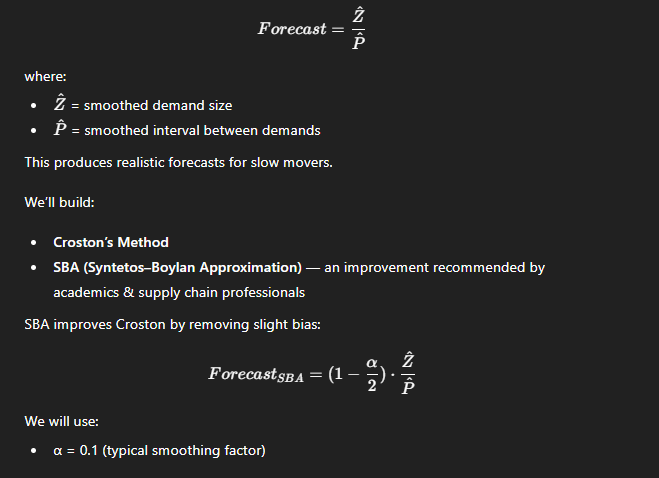



# STEP 7.1 — Implement Croston + SBA in Python

In [35]:
def croston_forecast(demand_series, alpha=0.1, method='sba'):
    """
    Croston and SBA forecasting for intermittent demand.
    demand_series: list/array of daily demand values
    method: 'croston' or 'sba'
    """
    demand = np.array(demand_series)

    # Initialize
    z = None   # demand size
    p = None   # interval
    q = 1      # interval counter

    for d in demand:
        if d > 0:  # non-zero demand day
            if z is None:
                z = d
                p = q
            else:
                z = z + alpha * (d - z)
                p = p + alpha * (q - p)
            q = 1
        else:
            q += 1

    if z is None:  # no demand at all
        return 0.0

    croston_forecast = z / p

    if method == 'sba':
        return (1 - alpha / 2) * croston_forecast
    else:
        return croston_forecast


# STEP 7.2 — Compute Forecast, ROP, OUT for Intermittent SKU

We extend the logic:

Demand forecast = Croston or SBA output

Lead-time demand = Forecast × Lead_Time

Safety stock: use a mild variability buffer (intermittent demand is too spiky to use σ properly)
→ We use Poisson approximation or 30–50% buffer

For now, we’ll use a pragmatic industry rule:


# SafetyStock=0.5×(Forecast×LeadTime)

You can tweak later.

In [36]:
def intermittent_policy(sku_df, alpha=0.1, method='sba'):
    sku_df = sku_df.sort_values('Activity_Date')
    demand_series = sku_df['Demand'].values

    # 1. Forecast using Croston/SBA
    fcst = croston_forecast(demand_series, alpha=alpha, method=method)

    # 2. Lead time and min pack from sku_df (already corrected)
    lead_time_raw = sku_df['Lead_Days'].iloc[0]
    if pd.isna(lead_time_raw) or lead_time_raw <= 0:
        lead_time = 35
    else:
        lead_time = int(lead_time_raw)

    min_pack_raw = sku_df['Min_Pack'].iloc[0]
    if pd.isna(min_pack_raw) or min_pack_raw <= 0:
        min_pack = 1
    else:
        min_pack = int(min_pack_raw)

    # 3. Expected demand during lead time
    lt_demand = fcst * lead_time

    # 4. Simple buffer-based safety stock (can tune)
    safety_stock = 0.5 * lt_demand

    rop_raw = lt_demand + safety_stock
    out_raw = lt_demand * 2 + safety_stock

    rop = int(np.ceil(rop_raw / min_pack)) * min_pack
    out = int(np.ceil(out_raw / min_pack)) * min_pack

    return {
        'forecast': fcst,
        'lt_demand': lt_demand,
        'safety_stock': safety_stock,
        'rop': rop,
        'order_up_to': out,
        'lead_time': lead_time,
        'min_pack': min_pack
    }


# STEP 7.3 — Run a Test for One Intermittent SKU

In [37]:
branch = 'CA'
item = '17A12TG'

sku_df_int = get_sku_timeseries(calendar_full, item_data, branch, item)

policy_int = intermittent_policy(sku_df_int)
policy_int


{'forecast': 0.02596706896965388,
 'lt_demand': 0.9088474139378858,
 'safety_stock': 0.4544237069689429,
 'rop': 36,
 'order_up_to': 36,
 'lead_time': 35,
 'min_pack': 36}

In [38]:
sim_res_int, sim_sum_int = simulate_sku_lost_sales(
    sku_df_int,
    rop=policy_int['rop'],
    order_up_to=policy_int['order_up_to']
)

sim_sum_int


{'total_demand': 82.0,
 'total_sales': 82.0,
 'total_lost_sales': 0.0,
 'fill_rate': 1.0,
 'avg_inventory': 91.58183632734531,
 'max_inventory': 97.0,
 'days_with_stockout_and_demand': 0,
 'rop': 36,
 'order_up_to': 36,
 'lead_time_days': 35,
 'min_pack': 36}

In [39]:
calendar_full[calendar_full['Item'] == '17A12TG'].head()


,Branch,Item,Activity_Date,Demand,Qty_on_Hand,PG_Major,PG_Minor,Min_Pack,Lead_Days,Stock_Flag
62124,CA,17A12TG,2023-01-01,0.0,97.0,NaN,NaN,36.0,35,NaN
62125,CA,17A12TG,2023-01-02,0.0,97.0,NaN,NaN,36.0,35,NaN
62126,CA,17A12TG,2023-01-03,0.0,97.0,NaN,NaN,36.0,35,NaN
62127,CA,17A12TG,2023-01-04,0.0,97.0,NaN,NaN,36.0,35,NaN
62128,CA,17A12TG,2023-01-05,0.0,97.0,NaN,NaN,36.0,35,NaN


In [40]:
item_data[(item_data['Branch'] == 'CA') & (item_data['Item'] == '17A12TG')]


,Branch,Item,Size,Description,Color,PG_Major,PG_Major_Description,PG_Minor,PG_Minor_Description,UOM,Stock_Flag,Min_Pack,Lead_Days


In [41]:
# Extract list of intermittent SKUs from your classification dataframe
# Assuming your dataframe is named `intermittent_skus`

intermittent_skuss = intermittent_skus[['Branch', 'Item']].drop_duplicates()

intermittent_results = []

for idx, row in intermittent_skuss.iterrows():
    branch = row['Branch']
    item = row['Item']

    print(f"Processing Intermittent SKU: {branch} – {item}")

    # 1. Get time series for this SKU
    try:
        sku_df = get_sku_timeseries(calendar_full, item_data, branch, item)
    except:
        # If no data, skip
        continue

    # 2. Compute forecast + ROP + OUT using Croston/SBA
    policy = intermittent_policy(sku_df)

    # 3. Run simulation
    sim_res, sim_sum = simulate_sku_lost_sales(
        sku_df,
        rop=policy['rop'],
        order_up_to=policy['order_up_to']
    )

    # 4. Append results
    intermittent_results.append({
        'Branch': branch,
        'Item': item,
        'Forecast': policy['forecast'],
        'LT_Demand': policy['lt_demand'],
        'SafetyStock': policy['safety_stock'],
        'ROP': policy['rop'],
        'OUT': policy['order_up_to'],
        'FillRate': sim_sum['fill_rate'],
        'LostSales': sim_sum['total_lost_sales'],
        'AvgInv': sim_sum['avg_inventory'],
        'MaxInv': sim_sum['max_inventory'],
        'StockoutDaysWithDemand': sim_sum['days_with_stockout_and_demand']
    })

# Convert to DataFrame
intermittent_df = pd.DataFrame(intermittent_results)

intermittent_df.head()


Processing Intermittent SKU: CA – 17A12TG
Processing Intermittent SKU: CA – 17A12TWH
Processing Intermittent SKU: CA – 17A13510SG
Processing Intermittent SKU: CA – 17A13512CS
Processing Intermittent SKU: CA – 17A13512DH
Processing Intermittent SKU: CA – 17A13512EW
Processing Intermittent SKU: CA – 17A13512MH
Processing Intermittent SKU: CA – 17A13512SG
Processing Intermittent SKU: CA – 17A13512WT
Processing Intermittent SKU: CA – 17A13516CS
Processing Intermittent SKU: CA – 17A13516CY
Processing Intermittent SKU: CA – 17A13516DH
Processing Intermittent SKU: CA – 17A13516EW
Processing Intermittent SKU: CA – 17A13516MH
Processing Intermittent SKU: CA – 17A13516OR
Processing Intermittent SKU: CA – 17A13516SG
Processing Intermittent SKU: CA – 17A13516WT
Processing Intermittent SKU: CA – 17A151212CS
Processing Intermittent SKU: CA – 17A151212CY
Processing Intermittent SKU: CA – 17A151212EW
Processing Intermittent SKU: CA – 17A151212WT
Processing Intermittent SKU: CA – 17A151216CS
Processing

,Branch,Item,Forecast,LT_Demand,SafetyStock,ROP,OUT,FillRate,LostSales,AvgInv,MaxInv,StockoutDaysWithDemand
0,CA,17A12TG,0.025967,0.908847,0.454424,36,36,1.000000,0.0,91.581836,97.0,0
1,CA,17A12TWH,0.028108,0.983797,0.491899,36,36,1.000000,0.0,228.115768,232.0,0
2,CA,17A13510SG,0.500357,17.512487,8.756244,104,104,0.953642,21.0,127.528942,184.0,1
3,CA,17A13512CS,1.168305,40.890689,20.445344,104,104,0.782988,199.0,106.410180,196.0,4
4,CA,17A13512DH,1.194285,41.799978,20.899989,104,208,0.597070,110.0,164.084830,273.0,1


# STEP 10 — Create stable_df with minimal policy & simulation results

In [42]:
import numpy as np
import pandas as pd

# STEP 1: Load the stable SKU list from your classification dataset
stable_list = stable_skus[['Branch', 'Item']].drop_duplicates()

stable_results = []

for idx, row in stable_list.iterrows():
    branch = row['Branch']
    item = row['Item']

    # These SKUs have no meaningful demand, so the policy is trivial
    stable_results.append({
        'Branch': branch,
        'Item': item,
        'Classification': 'Stable',

        # Forecasting fields
        'Forecast': 0,
        'LT_Demand': 0,
        'SafetyStock': 0,

        # Baseline policy (both zero)
        'Baseline_FillRate': 1.0,
        'Baseline_LostSales': 0,
        'Baseline_AvgInv': np.nan,
        'Baseline_MaxInv': np.nan,
        'Baseline_ROP': 0,
        'Baseline_OUT': 0,

        # Improved policy (same)
        'Improved_FillRate': 1.0,
        'Improved_LostSales': 0,
        'Improved_AvgInv': np.nan,
        'Improved_MaxInv': np.nan,
        'Improved_ROP': 0,
        'Improved_OUT': 0,

        # Stockout days
        'StockoutDaysWithDemand': 0
    })

# Convert to DataFrame
stable_df = pd.DataFrame(stable_results)

stable_df.head()


,Branch,Item,Classification,Forecast,LT_Demand,SafetyStock,Baseline_FillRate,Baseline_LostSales,Baseline_AvgInv,Baseline_MaxInv,Baseline_ROP,Baseline_OUT,Improved_FillRate,Improved_LostSales,Improved_AvgInv,Improved_MaxInv,Improved_ROP,Improved_OUT,StockoutDaysWithDemand
0,DET,17AG15520TWH,Stable,0,0,0,1.0,0,NaN,NaN,0,0,1.0,0,NaN,NaN,0,0,0
1,GR3,17AS13516CY,Stable,0,0,0,1.0,0,NaN,NaN,0,0,1.0,0,NaN,NaN,0,0,0
2,GR3,17AS13516WT,Stable,0,0,0,1.0,0,NaN,NaN,0,0,1.0,0,NaN,NaN,0,0,0
3,GR3,17AS13520CS,Stable,0,0,0,1.0,0,NaN,NaN,0,0,1.0,0,NaN,NaN,0,0,0
4,GR3,17AS13520MH,Stable,0,0,0,1.0,0,NaN,NaN,0,0,1.0,0,NaN,NaN,0,0,0


# STEP 11 — Combine Volatile + Intermittent + Stable into final master_df

In [43]:
import pandas as pd
import numpy as np

# 1) DEFINE THE FINAL COLUMN STRUCTURE EXPECTED FOR master_df

required_cols = [
    'Branch',
    'Item',
    'Classification',

    # Forecasting fields (used only for intermittent SKUs)
    'Forecast',
    'LT_Demand',
    'SafetyStock',

    # Baseline policy fields (used mainly for volatile)
    'Baseline_FillRate',
    'Baseline_LostSales',
    'Baseline_AvgInv',
    'Baseline_MaxInv',
    'Baseline_ROP',
    'Baseline_OUT',

    # Improved policy fields (used for all with simulation)
    'Improved_FillRate',
    'Improved_LostSales',
    'Improved_AvgInv',
    'Improved_MaxInv',
    'Improved_ROP',
    'Improved_OUT',

    # Simulation fields
    'StockoutDaysWithDemand'
]


# 2) ENSURE EACH DF HAS A CLASSIFICATION LABEL

volatile_df['Classification'] = 'Volatile'
intermittent_df['Classification'] = 'Intermittent'
stable_df['Classification'] = 'Stable'



# 3) STANDARDIZATION FUNCTION FOR EACH DATAFRAME

def standardize(df, label):
    """Ensure df has all required columns, fill missing with NaN, and reorder."""
    df = df.copy()

    # Add missing columns
    for col in required_cols:
        if col not in df.columns:
            df[col] = np.nan

    # Keep only required columns in correct order
    return df[required_cols]



# 4) APPLY STANDARDIZATION TO EACH CATEGORY

volatile_std = standardize(volatile_df, 'Volatile')
intermittent_std = standardize(intermittent_df, 'Intermittent')
stable_std = standardize(stable_df, 'Stable')



# 5) CONCATENATE ALL THREE CLEANED DATASETS

master_df = pd.concat(
    [volatile_std, intermittent_std, stable_std],
    ignore_index=True
)

# Remove any accidental exact duplicates (rare but safe)
master_df = master_df.drop_duplicates(subset=['Branch','Item','Classification'])

# Sort based on product identity for readability
master_df = master_df.sort_values(['Branch', 'Item']).reset_index(drop=True)



# 6) PRINT FINAL SHAPE AND DISTRIBUTION

print("master_df shape:", master_df.shape)
print(master_df['Classification'].value_counts())

# Preview
master_df.head()


master_df shape: (2260, 19)
Classification
Volatile        1568
Intermittent     631
Stable            61
Name: count, dtype: int64


,Branch,Item,Classification,Forecast,LT_Demand,SafetyStock,Baseline_FillRate,Baseline_LostSales,Baseline_AvgInv,Baseline_MaxInv,Baseline_ROP,Baseline_OUT,Improved_FillRate,Improved_LostSales,Improved_AvgInv,Improved_MaxInv,Improved_ROP,Improved_OUT,StockoutDaysWithDemand
0,CA,17A12AW,Volatile,NaN,NaN,NaN,1.000000,0.0,103.369261,194.0,72.0,144.0,1.000000,0.0,172.854291,266.0,144.0,216.0,NaN
1,CA,17A12BD,Volatile,NaN,NaN,NaN,0.724490,108.0,49.161677,71.0,36.0,36.0,0.982143,7.0,83.499002,109.0,72.0,72.0,NaN
2,CA,17A12BS,Volatile,NaN,NaN,NaN,1.000000,0.0,81.368263,140.0,72.0,108.0,1.000000,0.0,149.847305,212.0,144.0,180.0,NaN
3,CA,17A12CG,Volatile,NaN,NaN,NaN,0.755331,218.0,55.360279,155.0,36.0,72.0,0.988777,10.0,110.208583,177.0,108.0,144.0,NaN
4,CA,17A12CS,Volatile,NaN,NaN,NaN,0.814983,163.0,51.392216,106.0,36.0,72.0,0.903519,85.0,60.902196,106.0,72.0,72.0,NaN


In [44]:
master_df.head(10)
master_df['Classification'].value_counts()


Classification
Volatile        1568
Intermittent     631
Stable            61
Name: count, dtype: int64

In [45]:
total_baseline_lost = master_df['Baseline_LostSales'].sum()
total_improved_lost = master_df['Improved_LostSales'].sum()

total_baseline_inv = master_df['Baseline_AvgInv'].sum()
total_improved_inv = master_df['Improved_AvgInv'].sum()

print("Lost Sales - Baseline:", total_baseline_lost)
print("Lost Sales - Improved:", total_improved_lost)
print("Δ Lost Sales:", total_improved_lost - total_baseline_lost)

print("Avg Inventory - Baseline:", total_baseline_inv)
print("Avg Inventory - Improved:", total_improved_inv)
print("Δ Inventory:", total_improved_inv - total_baseline_inv)


Lost Sales - Baseline: 286440.0
Lost Sales - Improved: 112844.0
Δ Lost Sales: -173596.0
Avg Inventory - Baseline: 176783.42964071856
Avg Inventory - Improved: 286700.50399201596
Δ Inventory: 109917.0743512974


In [46]:
# SKUs where improved policy saved the most lost sales
master_df['LostSales_Saved'] = master_df['Baseline_LostSales'] - master_df['Improved_LostSales']

top_savings = master_df.sort_values('LostSales_Saved', ascending=False).head(20)


 # These are:

Top 20 SKUs where your algorithm really matters

In [47]:
import pandas as pd
import numpy as np

def seasonal_average_forecast(df, item, date_col='Activity_Date', qty_col='Demand', periods=12):
    """
    Simple, explainable, supply-chain forecast:
    - Monthly aggregation
    - Seasonal Index (12-month)
    - Recent 12-month rolling average as base level
    - Forecast = base * seasonal index

    Returns: pd.Series of next `periods` months forecast
    """

    # --- 1) Filter SKU ---
    sku = df[df['Item'] == item].copy()
    sku[date_col] = pd.to_datetime(sku[date_col])

    # Monthly demand
    monthly = sku.set_index(date_col).resample('MS')[qty_col].sum()

    if monthly.sum() == 0:
        return pd.Series(np.zeros(periods),
                         index=pd.date_range(monthly.index[-1] + pd.offsets.MonthBegin(),
                                             periods=periods, freq='MS'))

    # --- 2) Compute Seasonal Indices ---
    monthly_df = monthly.to_frame('demand')
    monthly_df['month'] = monthly_df.index.month

    # overall monthly average
    overall_avg = monthly_df['demand'].mean()

    # seasonal index per month
    seasonal_index = monthly_df.groupby('month')['demand'].mean() / overall_avg

    # if single year or no seasonality, fallback to 1.0
    seasonal_index = seasonal_index.reindex(range(1, 13), fill_value=1.0)

    # --- 3) Base Level = rolling 12-month average ---
    if len(monthly_df) >= 12:
        base_avg = monthly_df['demand'].tail(12).mean()
    else:
        base_avg = monthly_df['demand'].mean()  # fallback

    # --- 4) Forecast next N months ---
    fcst_index = pd.date_range(monthly.index[-1] + pd.offsets.MonthBegin(),
                               periods=periods, freq='MS')

    fcst_values = []
    for t in fcst_index:
        m = t.month
        fcst_values.append(base_avg * seasonal_index[m])

    return pd.Series(fcst_values, index=fcst_index)


In [48]:
item = "17TESG5416CH"   # <-- change SKU here if needed

sku = calendar_full[calendar_full['Item'] == item].copy()
sku['Activity_Date'] = pd.to_datetime(sku['Activity_Date'])

# Historical monthly demand
monthly = sku.set_index('Activity_Date').resample('MS')['Demand'].sum()
monthly


Activity_Date
2023-01-01     273.0
2023-02-01     301.0
2023-03-01     490.0
2023-04-01     833.0
2023-05-01    1204.0
2023-06-01    1821.0
2023-07-01    1108.0
2023-08-01    1229.0
2023-09-01    1228.0
2023-10-01    1090.0
2023-11-01    1275.0
2023-12-01     190.0
2024-01-01     529.0
2024-02-01     648.0
2024-03-01     603.0
2024-04-01    1693.0
2024-05-01    2567.0
2024-06-01    1767.0
2024-07-01    1842.0
2024-08-01    1040.0
2024-09-01    1348.0
2024-10-01    1277.0
2024-11-01     457.0
2024-12-01     361.0
2025-01-01     647.0
2025-02-01     175.0
2025-03-01     705.0
2025-04-01    1084.0
2025-05-01    2058.0
2025-06-01    2197.0
2025-07-01    2376.0
2025-08-01    1291.0
2025-09-01     857.0
Freq: MS, Name: Demand, dtype: float64

In [49]:
forecast = seasonal_average_forecast(
    df=calendar_full,
    item=item,
    periods=6
)
forecast


2025-10-01    1200.323218
2025-11-01     878.310018
2025-12-01     279.416178
2026-01-01     489.865749
2026-02-01     379.992479
2026-03-01     607.852738
Freq: MS, dtype: float64

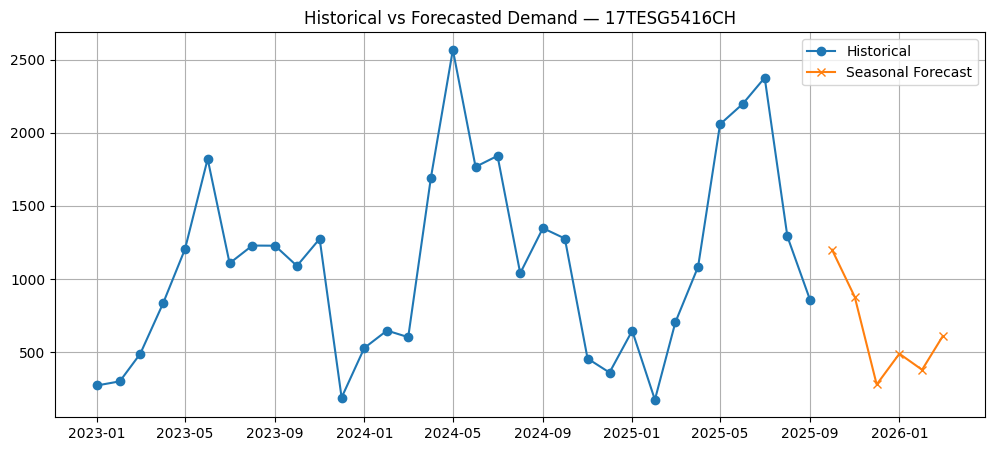

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(monthly, label="Historical", marker='o')
plt.plot(forecast, label="Seasonal Forecast", marker='x')
plt.grid(True)
plt.legend()
plt.title(f"Historical vs Forecasted Demand — {item}")
plt.show()


In [51]:
skus_to_forecast = [
    "17TESG5416CH",
    "17TESG5412CH",
    "17TESG5420CH",
    "17A12TG",
    "17A13510SG"
]


In [52]:
def plot_forecast(df, item, periods=6, date_col='Activity_Date', qty_col='Demand'):
    # --- Historical ---
    sku = df[df['Item'] == item].copy()
    sku[date_col] = pd.to_datetime(sku[date_col])

    monthly = sku.set_index(date_col).resample('MS')[qty_col].sum()

    # If all zeros, skip
    if monthly.sum() == 0:
        print(f"\nSKU: {item} has no demand history.")
        return None

    # --- Forecast ---
    forecast = seasonal_average_forecast(
        df=df,
        item=item,
        periods=periods
    )

    # --- Plot ---
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,5))
    plt.plot(monthly, label="Historical Demand", marker='o')
    plt.plot(forecast, label="Forecast", marker='x')
    plt.grid(True)
    plt.legend()
    plt.title(f"Historical vs Forecast Demand — {item}")
    plt.xlabel("Month")
    plt.ylabel("Units")
    plt.show()

    return forecast



 Forecasting SKU: 17TESG5416CH


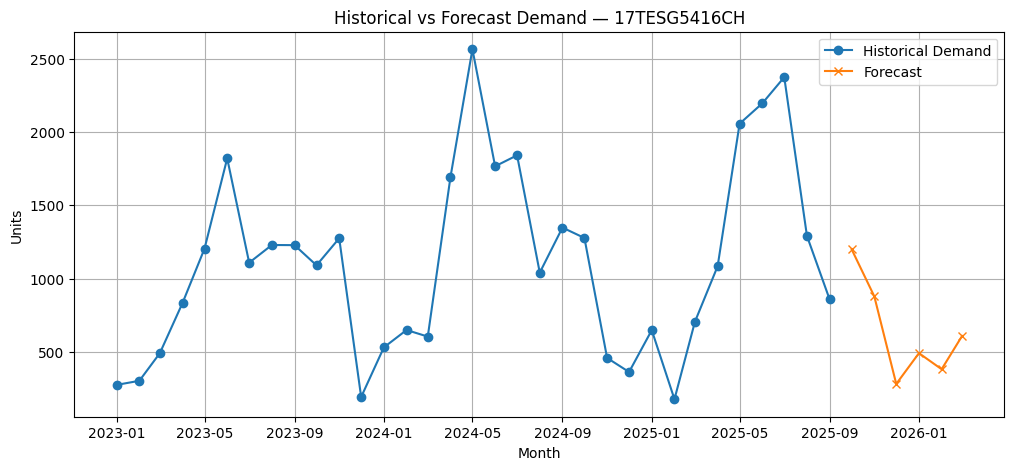


 Forecasting SKU: 17TESG5412CH


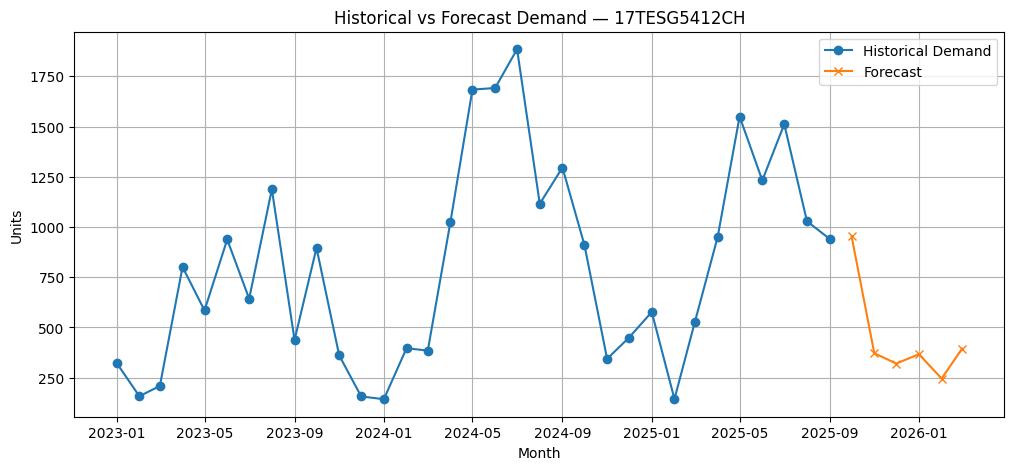


 Forecasting SKU: 17TESG5420CH


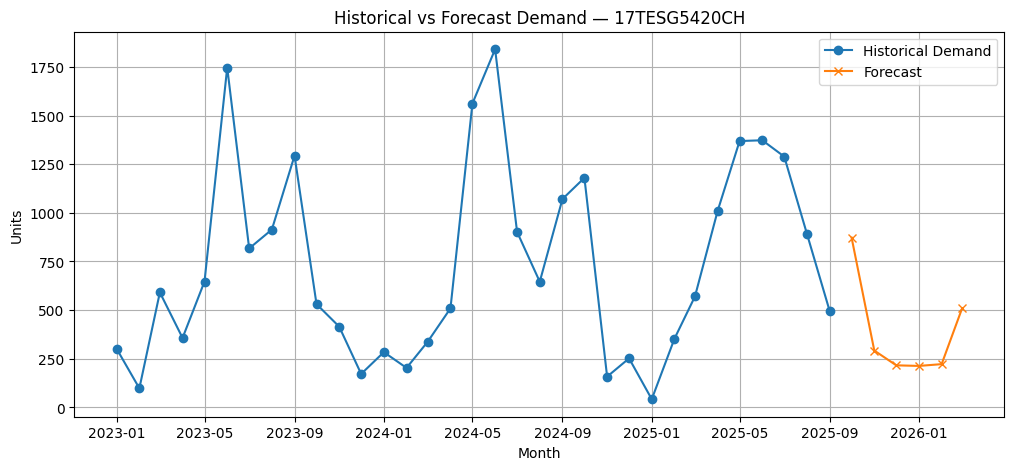


 Forecasting SKU: 17A12TG


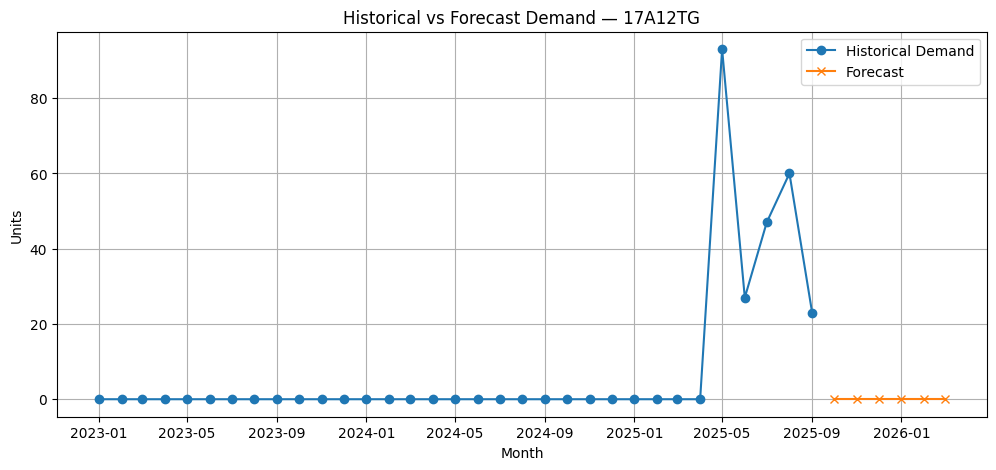


 Forecasting SKU: 17A13510SG


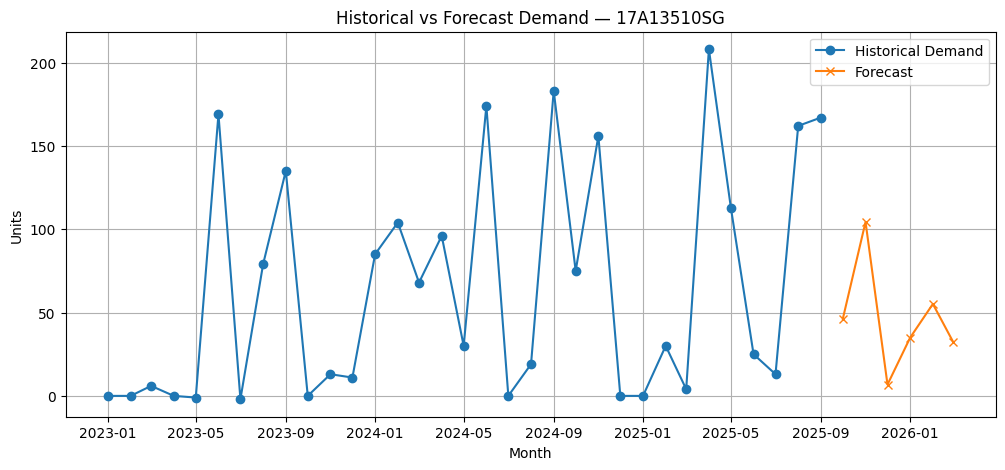

In [53]:
forecasts = {}

for sku in skus_to_forecast:
    print(f"\n==============================")
    print(f" Forecasting SKU: {sku}")
    print(f"==============================")

    fcst = plot_forecast(calendar_full, sku, periods=6)
    forecasts[sku] = fcst


# Create the Multi-SKU Forecast Function

In [54]:
def forecast_all_skus(df, periods=12):
    """
    Generate seasonal-average forecast for ALL SKUs in the dataset.

    Returns:
        master_forecast_df: DataFrame with columns:
        Branch, Item, Forecast_M1 ... Forecast_M12
    """
    forecast_rows = []

    # List of unique Branch–Item pairs
    sku_list = df[['Branch', 'Item']].drop_duplicates()

    for idx, row in sku_list.iterrows():
        branch = row['Branch']
        item = row['Item']

        # Filter for SKU+Branch data
        subset = df[(df['Branch'] == branch) & (df['Item'] == item)]

        # Run seasonal forecast model
        fcst = seasonal_average_forecast(
            df=subset,
            item=item,
            periods=periods
        )

        # Create one row per SKU
        fcst_dict = {
            'Branch': branch,
            'Item': item
        }

        # Add forecast horizon columns: Forecast_M1 ... Forecast_M12
        for i in range(periods):
            fcst_dict[f'Forecast_M{i+1}'] = float(fcst.iloc[i])

        forecast_rows.append(fcst_dict)

    return pd.DataFrame(forecast_rows)


# Run It on All 2,260 SKUs

In [55]:
master_forecast_df = forecast_all_skus(calendar_full, periods=12)



# Inspect Output

In [56]:
master_forecast_df

,Branch,Item,Forecast_M1,Forecast_M2,Forecast_M3,Forecast_M4,Forecast_M5,Forecast_M6,Forecast_M7,Forecast_M8,Forecast_M9,Forecast_M10,Forecast_M11,Forecast_M12
0,CA,17A12AW,13.129996,22.185165,26.259991,10.866203,3.622068,5.433102,52.519983,38.937228,47.086881,25.958152,74.252389,47.690559
1,CA,17A12BD,7.808036,0.000000,0.000000,0.000000,0.000000,0.000000,4.957483,20.821429,-0.495748,25.035289,24.043793,17.599065
2,CA,17A12BS,13.232399,6.616200,13.232399,10.897270,1.816212,7.264847,17.124282,0.518918,33.210728,35.805316,11.935105,39.956657
3,CA,17A12CG,6.172840,3.703704,0.246914,6.584362,7.407407,8.065844,19.423868,21.069959,16.131687,10.699588,27.818930,22.716049
4,CA,17A12CS,19.075199,7.079455,4.522985,2.884222,3.933031,3.539728,11.012486,15.469921,15.601022,14.421112,13.372304,14.814415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,TO,17TS5420RC,16.772860,10.165370,0.508268,0.000000,10.504215,3.727302,4.404994,24.396887,10.165370,5.082685,14.570363,-4.066148
1625,TO,17TS5420SM,9.670149,3.275373,4.367164,-0.727861,2.287562,11.021891,14.245274,11.333831,1.247761,8.318408,2.391542,8.006468
1626,TO,17TS5420TW,3.312044,14.131387,0.000000,0.000000,0.147202,9.126521,9.568127,5.446472,11.334550,30.323601,13.100973,10.156934
1627,TO,17TS5420WC,0.549061,12.811433,-12.811433,0.000000,0.000000,0.366041,0.732082,0.732082,8.784983,6.954778,2.684300,15.129693


In [58]:
output_path = "Forecast_All_SKUs.xlsx"

master_forecast_df.to_excel(
    output_path,
    index=False,
    sheet_name='Forecast'
)

output_path


'Forecast_All_SKUs.xlsx'

In [60]:
# 1) Save as CSV
calendar_full.to_csv("calendar_full.csv", index=False)

